## Basic Featurisation of Protein Surfaces

In this notebook, we will use [FEATURE](https://bmcgenomics.biomedcentral.com/articles/10.1186/1471-2164-9-S2-S2), an early work by Altman et al, to capture information on protein surfaces. e.g. atom types, residue, chemical groups, secondary structure, hydrophobicity, charges, solvent accessibility, etc. Many of the properties in the Altman features are discrete empirical counts in unit of atoms present within some radial shells; each shell has a thickness of 1.25 angstrom. The Altman vectors are sparse and largely discrete, but intuitive to undertsand. Therefore, it serves as a good starting point before jumping to more sophisticated featurisation systems e.g. [MASIF](https://github.com/LPDI-EPFL/masif), etc. Some other properties on the Altman vectors includes:

* Relation between shells and sites. The radial framework and counting scheme  implies that for any plausible site (i.e. the empty volume where centroids of base and backbone may be located) the first two shells collected on the site (i.e. the volume within 2.5 angstroms of the site) will be zero as sites can rarely locate within 2.5 angstrom of any protein heavy atoms. Therefore, it is adviced to discard the first two shells. 

* Spacing of Halo. Atoms (very) rarely locate closer than 1.25 angstrom. For training with the Altman vectors, narrowing the halo spacing will result in many repeated input vectors due to the discrete counting scheme. Currently, the spacing is 1 angstrom (i.e. with a diagonal spacing max at square root of 3).

* Amount of information. The closer a voxel to the protein, the less sparse will be the Altman vector. Note that the number of unanimously zero shells reflects the distance to the protein, which can be an important information. It is also adviced to z-score the features to avoid huge difference in range of numbers among shells as counts inflate among outer shells.




## Content of the Notebook

This note book will go through two tasks. 
* Collecting Altman vectors. We provide a storage-efficient parallelised protocol to collect the vectors. We will store it in [CSR](http://scipy-lectures.org/advanced/scipy_sparse/csr_matrix.html#:~:text=Compressed%20Sparse%20Row%20Format%20%28CSR%29%20%C2%B6%201%20indices,indices%20indices%20%5Bindptr%20%5Bi%5D%3Aindptr%20%5Bi%2B1%5D%5D%20More%20items...%20) to facilitate later retrieval.
* Collecting statistics. The resultant dataset in full takes > 80 GB to store > 4,000,000,000 vectors (4 billions!). Statistics has to be collected with incremental methods. This is important as the vector has to be standardised. We will also look into the correlation among the Altman features, comment on some of their properties, and extract a useful basis for the Altman vectors, which can be useful in later development.


## Imports

In [1]:
# ============== Imports
import sys
import glob
import tqdm 

import pandas as pd
import numpy as np

from scipy import sparse

import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append('../')


%config InlineBackend.figure_format = 'svg'
sns.set_context("notebook")


## Collection of Altman vectors

Cells below start collection of the Altman vectors, which will be stored as multiple compressed npz file in sparse CSR matrix format. Remarks.
* System requirement. Allow > 100 GB storage for ~44000 files and at least 16 GB RAM. 
* Time to complete. The FEATURE program do counts (../../NucleicNet/util/feature-3.1.0/src/Neighborhood.cc) with spatial decomposition but it still can take a long time to process. Allow around 4-5 days. We can stop the program, it will detect files generated, but currently we do not implement check sum.


The output downstream of the vanilla program is stored as a string text file {pdbid}.ff; this format can waste a lot of storage/memory as it does not handle the sparsity. Note that the largest pdb file 6icz will take more than 2GB just for the program to write out the entire 6icz.ff in an hour. To avoid storage stress, we will process the output in memory and package it as multiple sparse CSR array with npz compression. We will use the following filename format.

* {pdbid}.altman.{startindex}.npz.

Note that the processing in memory also means multiple {pdbid}.ff will be written into memory. Hence, unless you have a workstation with huge memory pool, it is suggested to use no more than 4-5 workers. 

In [2]:

from NucleicNet.DatasetBuilding.util import *
from NucleicNet.DatasetBuilding.commandHalo import Halo
from NucleicNet.DatasetBuilding.commandFeaturisation import Featurisation


pdbavail = sorted(glob.glob( "../Database-PDB/halo" + "/*.halotup"))
filesize = [os.path.getsize(i) for i in pdbavail]
pdbavail = [pdbavail[i] for i in np.argsort(filesize).tolist()]
#print("Check on an example size")
#print(dict(zip(pdbavail,filesize))['../Database-PDB/halo/4f4z.halotup'])



FeaturisationC = Featurisation(        
        DIR_OutputFeatureVector = "../Database-PDB/feature",
        DIR_InputPdbFolder = "../Database-PDB/apo", 
        DIR_InputHaloFolder = "../Database-PDB/halo", 
        DIR_DsspExecutable = "../NucleicNet/util/dssp",
        DIR_AltmanFolder = "../NucleicNet/util/feature-3.1.0/",
        n_multiprocessingworkers= 5,
        UpdateExist = False,SavingFeature = True)
FeaturisationC.Altman()

There are 12561 structure PDB files ready for analysis
There are 28 structure PDB files remained to be analysed
Start Multiprocessing


  0%|          | 0/3 [00:00<?, ?it/s]FEATURE_DIR: /home/homingla/Project-NucleicNet/NucleicNet/util/feature-3.1.0/data/
verbosity: 0
numShells: 8
shellWidth: 1.25
excludeResidues: 1 [ HETATM  ]
pdbids: 1 [ 7o7500000000  ]
search path: /home/homingla/Project-NucleicNet/Database-PDB/apo/7o7500000000.pdb
FEATURE_DIR: /home/homingla/Project-NucleicNet/NucleicNet/util/feature-3.1.0/data/
verbosity: 0
numShells: 8
shellWidth: 1.25
excludeResidues: 1 [ HETATM  ]
pdbids: 1 [ 7o7300000000  ]
search path: /home/homingla/Project-NucleicNet/Database-PDB/apo/7o7300000000.pdb
FEATURE_DIR: /home/homingla/Project-NucleicNet/NucleicNet/util/feature-3.1.0/data/
verbosity: 0
numShells: 8
shellWidth: 1.25
excludeResidues: 1 [ HETATM  ]
pdbids: 1 [ 7o7200000000  ]
search path: /home/homingla/Project-NucleicNet/Database-PDB/apo/7o7200000000.pdb
FEATURE_DIR: /home/homingla/Project-NucleicNet/NucleicNet/util/feature-3.1.0/data/
verbosity: 0
numShells: 8
shellWidth: 1.25
excludeResidues: 1 [ HETATM  ]
pdbids: 

## Retrieval of Sparse Classes and Features
Now we have collected some Altman vectors {pdbid}.altman.{startingindex}.npz. We had also collected the classes of the vectors through {pdbid}.typi.npz collected in previous notebooks. We will read into one of the pdbids to illustrate fast access of classes and features through row indexing of the CSR format. This will allow fast construction of pytorch dataset in later notebooks. Also note that neighbors of mesh/halo can be easily retrieved with kDtree. Below we will also illustrate the sparsity of Altman vectors, where I picked a large polymerase for example. The display is binary.

(9178, 481) (309926, 481)


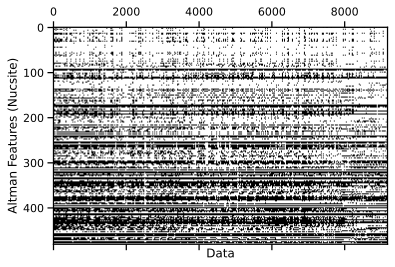

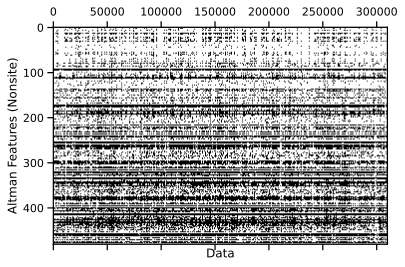

In [3]:
# NOTE Column 10 is nucsite_ column 11 is nonsite_
from NucleicNet.DatasetBuilding.commandFeaturisation import FindContainer_ByClass, FindFeature_ByContainer
pdbid = "2nvq"

with np.load("../Database-PDB/typi/%s.typi.npz" %(pdbid)) as f:
        typi = sparse.csr_matrix((f['data'], f['indices'], f['indptr']), shape= f['shape'])

print(typi.shape)
nucsite_containerdict, nucsite_rowindex = FindContainer_ByClass(typi, classindex = 10, n_row_maxhold = 10000)
nonsite_containerdict, nonsite_rowindex = FindContainer_ByClass(typi, classindex = 11, n_row_maxhold = 10000)

nucsite_feature = FindFeature_ByContainer(nucsite_containerdict, 
                                DIR_Feature = "../Database-PDB/feature/",
                                pdbid = pdbid, featuretype = "altman", returndense= True)

nonsite_feature = FindFeature_ByContainer(nonsite_containerdict, 
                                DIR_Feature = "../Database-PDB/feature/",
                                pdbid = pdbid, featuretype = "altman", returndense= True)
print(nucsite_feature.shape, nonsite_feature.shape)
#print(nonsite_containers.keys(), nucsite_containers.keys())
plt.spy(nucsite_feature.T, precision=0, marker=None, markersize=None, aspect='auto')
plt.xlabel("Data")
plt.ylabel("Altman Features (Nucsite)")
plt.show()

plt.spy(nonsite_feature.T, precision=0, marker=None, markersize=None, aspect='auto')
plt.xlabel("Data")
plt.ylabel("Altman Features (Nonsite)")
plt.show()


## Future Directions
In this implementation, we built some routines to allow fast access of features, classes and mesh coordinates. We hope that this will facillitate training with message passing among voxels which we did not accomplish in our first implementation. We also looked into some properties of the Altman vectors. In the next notebook, we will study the statistics of these vectors more carefully.
